# Final Exam Project
## for the class on Collecting and Analyzing Big Data
---
Daria Dementeva - r0771521


Nina Morgenstern - r0772330

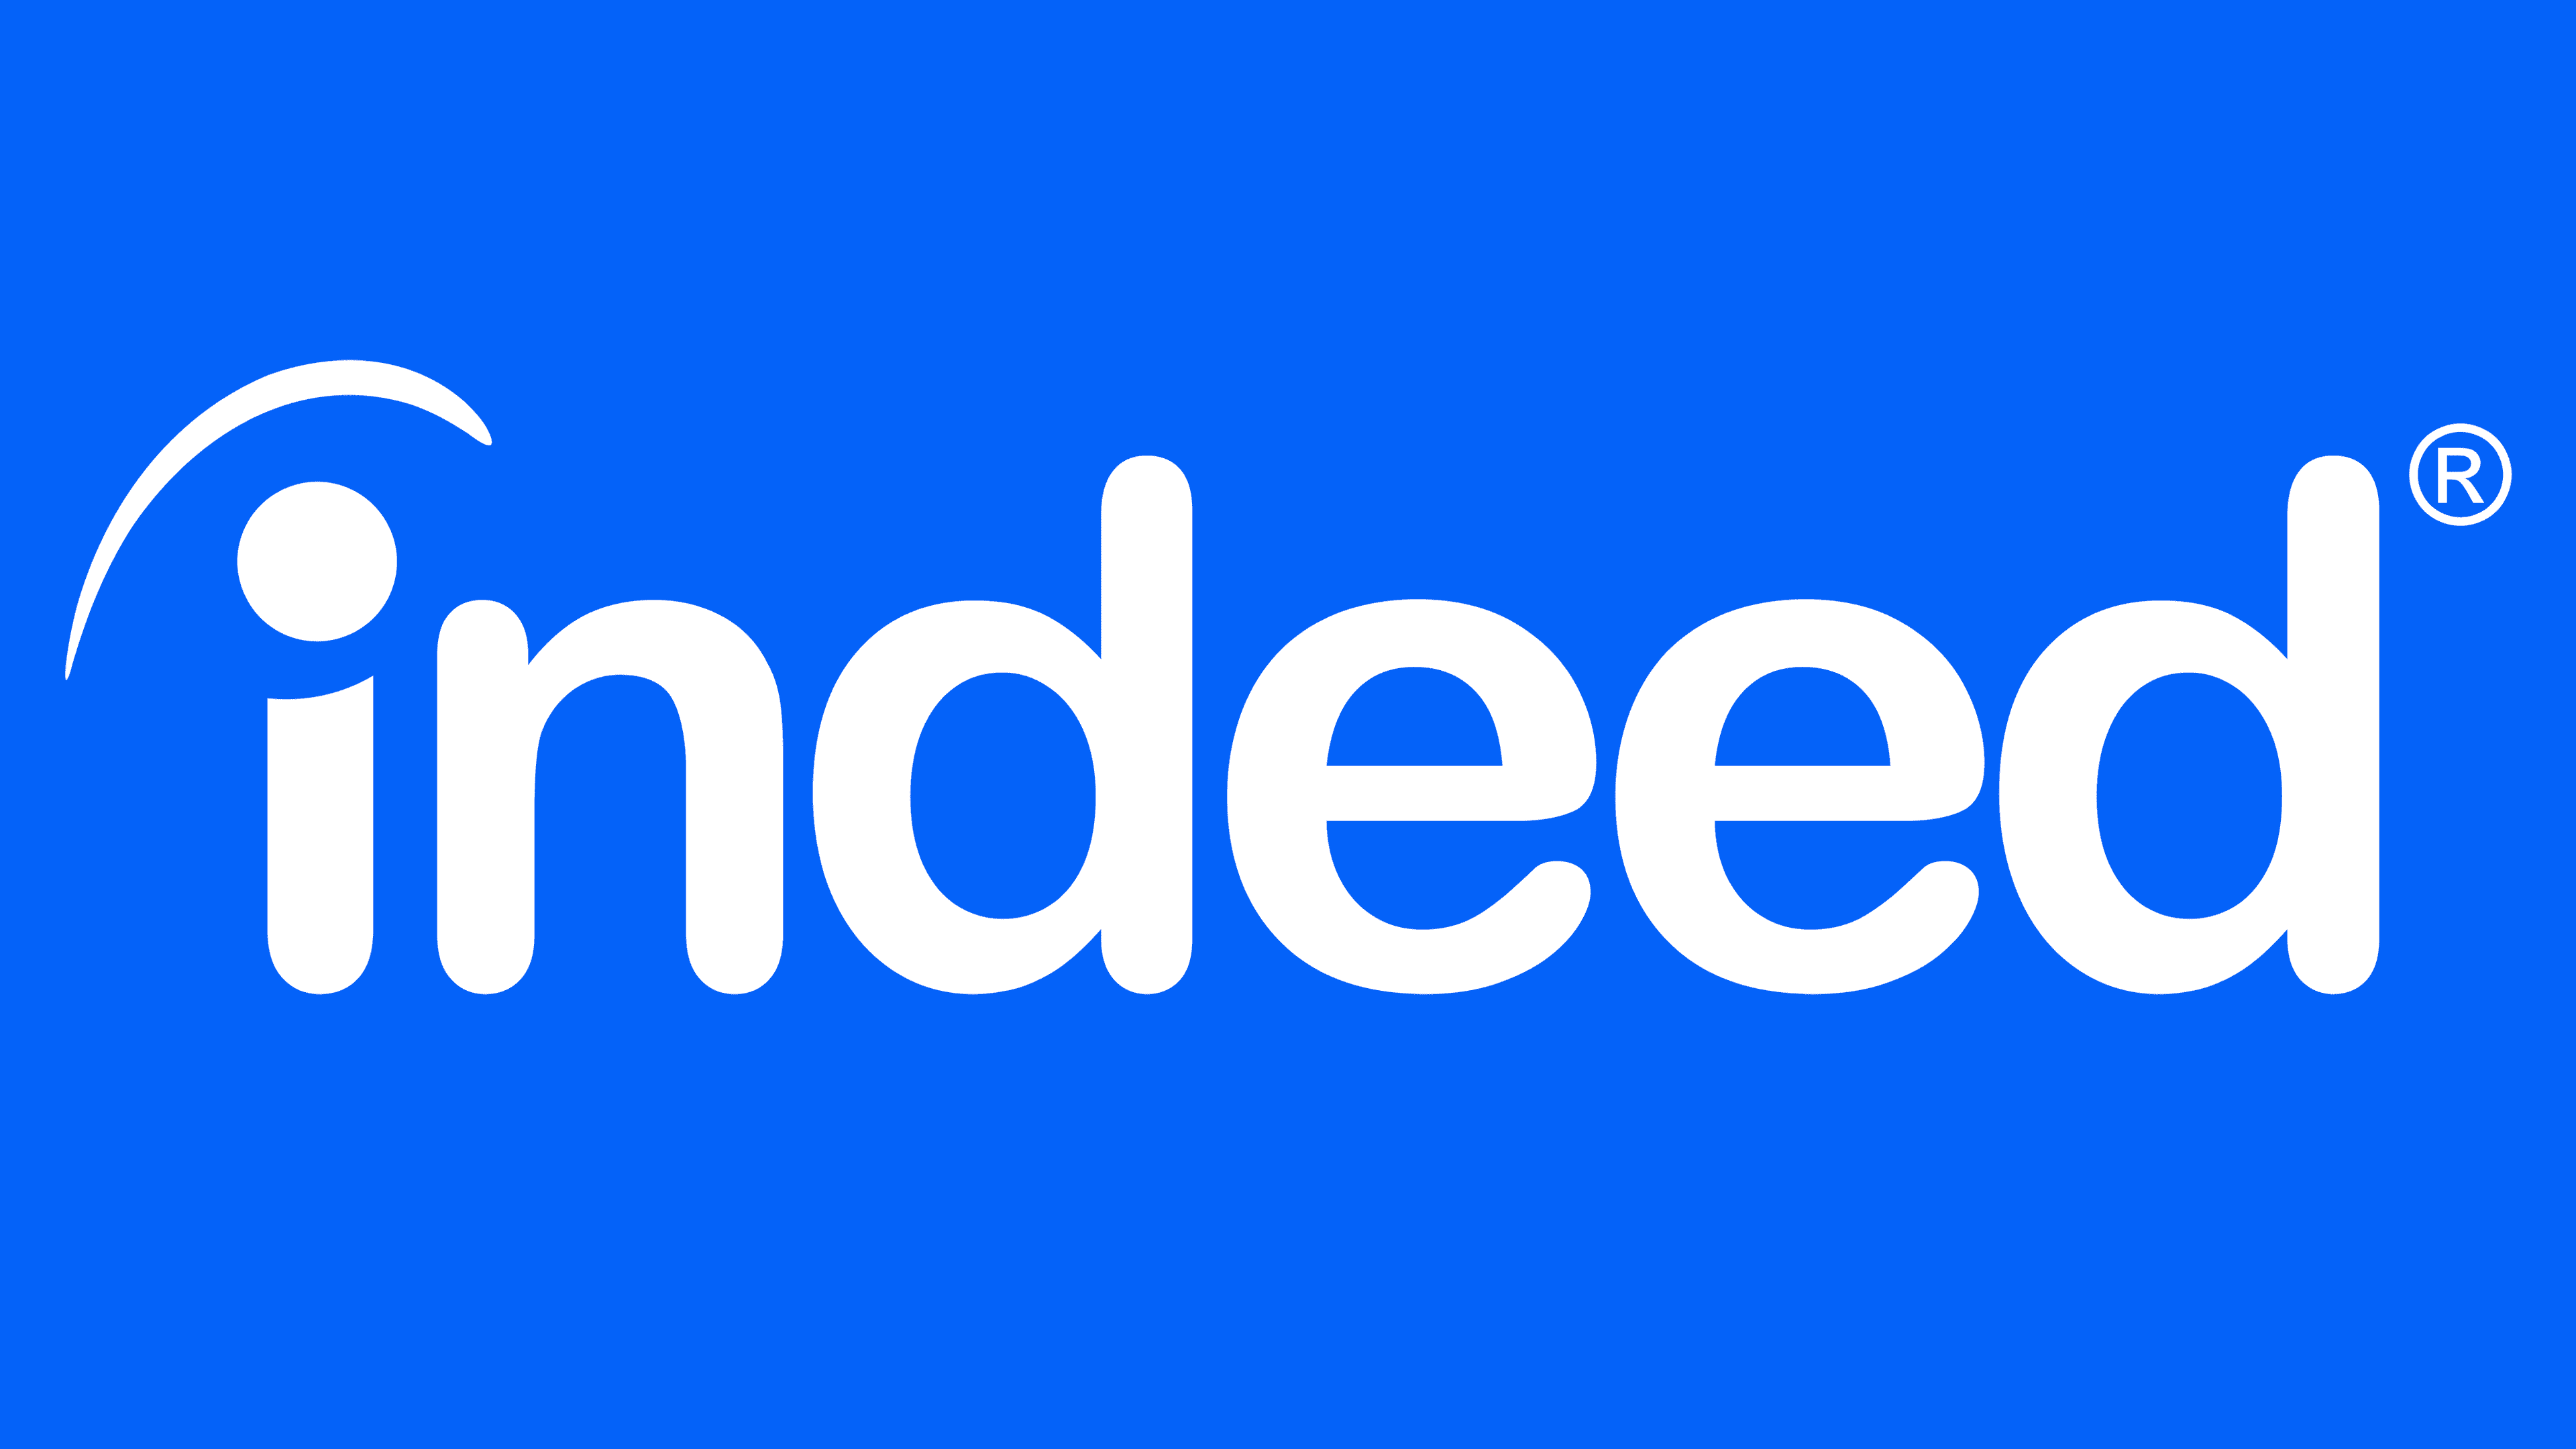

Indeed is one of the biggest websites for job listings and the highest-traffic job website in the United States. As soon-to-be graduates, we spend already quite some time on Indeed looking at jobs for after our Master's degree in Statistics and Data Science. Data Science related jobs are in demand and Indeed is full of them. With our analysis we want to have an insight into the Belgian job market for data related jobs. We want to find out what the demanded skills are and what topics appear in job descriptions.  We are especially interested in the job descriptions for listings appearing under different search terms. Is there a difference between jobs recommended when searching for Data Analyst, Data Scientist, Data Engineer, Machine Learning Engineer and Buisness Intelligence? Since Belgium is a multiligual country, we are interested which job titles are most often posted in English. Finally, we want to find out if the job description is predictive for the search term under which a job appears.

The first step of the analysis is to scrape Indeed to aquire the job descriptions. This poses several challenges as Indeed is not easy to scrape. Once we obtain the text from the scraping we prepare and clean it for our analysis. We will apply some descriptive analysis such as looking at the word frequency distribution and n-grams. We will implement topic modeling with LDA and Top2Vec. Finally, we will build a multiclass classification model on the dataset.

In [ ]:
# Imports for plotting Google trends
%pip install pytrends
from pytrends.request import TrendReq
import plotly.io as pio
import plotly.express as px

# API to get Google search data
pytrends = TrendReq()
pytrends.build_payload(['Data Scientist', 'Data Analyst', 'Data Engineer', 'Machine Learning Engineer', 'Business Intelligence'], timeframe='today 5-y')
df = pytrends.interest_over_time()
# prepare data for plot
df.drop('isPartial', axis=1, inplace=True)
data = pd.melt(df.reset_index(), id_vars='date', var_name = 'search_term', value_name = 'search_volume' )
# plotly 
fig = px.line(data, x="date" , y = "search_volume", color="search_term", line_group = "search_term", labels={"date": "Date", "search_volume": "Search Volume", "search_term": "Search"},
              title="Comparison of Google Searches")
fig.show()

# Imports

In the first step, we import the necessary packages for our anaylsis.

In [ ]:
#Installations
!pip install langdetect
!pip install fake-useragent
!pip install top2vec

#Basic packages
import pandas as pd
import re
import math
import time
import numpy as np
import top2vec

#Web scraping packages
import requests
from bs4 import BeautifulSoup
from fake_useragent import UserAgent
from langdetect import detect

#NLP packages
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.collocations import *
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt

#ML packages
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from top2vec import Top2Vec


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Web Scraping

The most difficult step of the analysis is to aquire the data. Since Indeed does not provide an API, we perform web scraping to get the job descriptions for different search terms. We used a trail and error strategy to find the right selector paths. We define functions to help us with the web scraping process: 

*   **get_number_of_iterations**: We inspect the structure of the URL to understand how to send our requests. The jop postings strech over multiple pages and we need to find out how many pages of postings to scan. We use BeautifulSoup to get the document as a nested data structure. We select the #searchCountPages in our soup to see how many postings there are in total, divide by the limit of postings displayed per page and round this value up.  Because we do not want get banned by the website, we use a random user agent for our requests.
*   **get_links**: Function to harvest the link to a job posting from the soup object.
*   **visible_texts**: Function to get the description text (body) from the soup and remove unnecessary whitespaces and the javascript code. 
*   **get_clean_text**: Create a BeautifulSoup object and apply the visible_texts function
*   **detect_language**: Detects the language a job posting is written in. For job postings in Belgium: English, French, Dutch or Unknown.
*   **sub_common_strings**: Every job description text starts and ends with the same senteces. This function removes these unnecessary senteces using regular expressions, since these senteces are irrelevant for our analysis.










In [ ]:
# Functions

def get_number_of_iterations(query, limit):
    URL = 'https://be.indeed.com/jobs?q=' + query +  '&l=belgium&limit=' + str(limit) + '&filter=' + str(0) + '&start=' + str(0)
    ua = UserAgent()
    header = {'User-Agent':str(ua.random)}
    webpage_request = requests.get(URL, headers = header)
    soup = BeautifulSoup(webpage_request.content, "html.parser")
    replaced_search_count = (soup.select('#searchCountPages')[0].text).replace('.', '')
    iterations = math.ceil(int(re.findall(r"\d+", replaced_search_count)[1])/limit)-1
    return iterations

def get_links(soup):
    links = []
    for link in soup.findAll('a'):
        if (len(re.findall(r"^/pagead/.*", str(link.get('href')))) + len(re.findall(r"^/rc/.*", str(link.get('href')))) > 0):
            links.append(link.get('href'))
    return links

def visible_texts(soup):
    re_spaces = re.compile(r'\s{3,}')
    text = ' '.join([s for s in soup.strings if s.parent.name not in ('style', 'script', 'head', 'title')])
    return re_spaces.sub(' ', text)

def get_clean_text(html):
    soup_temp = BeautifulSoup(html)
    visible_temp = visible_texts(soup_temp)
    return visible_temp
    
def detect_language(cleaned_text):
    lang = 'Unknown'
    try:
        lang = detect(cleaned_text)
    except:
        lang = 'Unknown'
    return lang
    
def sub_common_strings(cleaned_text):
    temp_cleaned_text = re.sub(r"^.*zoeken Geavanceerd zoeken ", "", cleaned_text)
    temp_cleaned_text = re.sub(r"Carrièregids Bladeren door vacatures.*$", "", temp_cleaned_text)
    return temp_cleaned_text

We decided to scrape the job postings for certain search terms. We were interested in the search results for "Business Intelligence", "Data Scientist", "Data Analyst", "Data Engineer" and "Machine Learning Engineer". Note that we were not able to scrape all search terms at once due to internet connection issues and requests coming back empty. We splitted the scraping, concatinated the dataframes and dropped duplicates.

In [ ]:
job_categories = ['business+intelligence', 'data+scientist', 'data+analyst', 'data+engineer', 'machine+learning+engineer']

Next, we gather the links to the job postings on Indeed. We use our user-agent and define the **indeed_job_frame** which will hold our data including links (Ad_Link) and search term (Job_Category). We set the limit of job postings per page to 50 (the maximum). We loop over the categories and number of pages for each categories. We keep track of the category and link by appending them to the meta_link_list and meta_category_list. To not overload the website and get banned, we us the sleep function with a 10s gap between every request.
The structure of the URL can be seen below. First hellooo


In [ ]:
filter_boolean = 0
limit = 50
ua = UserAgent()

indeed_job_frame = pd.DataFrame({'Job_Category': [], 'Ad_Link': []})

meta_category_list = []
meta_link_list = []

counter = 0
for category in job_categories:
    iterations = get_number_of_iterations(category, limit)
    for page in range(iterations):
        page_num = page*50
        URL = 'https://be.indeed.com/jobs?q=' + category +  '&l=belgium&limit=' + str(limit) + '&filter=' + str(filter_boolean) + '&start=' + str(page_num)
        header = {'User-Agent':str(ua.random)}
        webpage_request = requests.get(URL, headers = header)
        soup = BeautifulSoup(webpage_request.content, "html.parser")
        meta_link_list += get_links(soup)
        for count in range(len(get_links(soup))):
            meta_category_list.append(category)
        counter += 1
        print(category, iterations, counter)
        time.sleep(10)

We insert the meta_category_list and the meta_link_list as a columns to our indeed_job_frame and drop and duplicate rows. We see how many jobs posting links from which search term we harvested.

In [ ]:
indeed_job_frame['Job_Category'] = meta_category_list
indeed_job_frame['Ad_Link'] = meta_link_list
indeed_job_frame = indeed_job_frame.drop_duplicates()
indeed_job_frame.Job_Category.value_counts()

We use the gathered links to request the html data for each job posting. We append each request to the meta_html_list, which put as a column in out indeed_job_frame. We also include the sleep function with a 10s gap between the requets. This makes the process time consuming but we are not overwhelming the server with requests.

In [ ]:
Counter = 0
meta_html_list = []
for indeed_ad in indeed_job_frame.Ad_Link.tolist():
    URL = 'https://be.indeed.com' + str(indeed_ad)
    header = {'User-Agent':str(ua.random)}
    webpage_request = requests.get(URL, headers = header)
    meta_html_list.append(webpage_request.text)
    if (Counter % 100 == 0):
        print(Counter,'Jobs processed')
    Counter += 1
    time.sleep(10)
    
indeed_job_frame['HTML'] = meta_html_list

Here we apply the cleaning function on the HMTL column to extract the text and use the language detector to label the language a job posting is written in. We drop the HTML column from the data frame and save the results as a csv.

In [ ]:
#apply cleaning function
indeed_job_frame['Cleaned_Text'] = indeed_job_frame.HTML.apply(get_clean_text)    
#detect language of job descriptions
indeed_job_frame['Language'] = indeed_job_frame.Cleaned_Text.apply(detect_language)
#remove common strings
indeed_job_frame['Cleaned_Text'] = indeed_job_frame.Cleaned_Text.apply(sub_common_strings)
#drop the HTML column to get a lighter file
indeed_job_frame.drop('HTML',axis=1, inplace=True)
#save as csv for further analysis
indeed_job_frame.to_csv(r'/Users/ninamorgenstern/Desktop/jobs_indeed.csv', index = False)
indeed_job_frame

# Text preparation

Before proceeding to our analyses, we have to pre-process our textual data.  First, we select only the descriptions published in English. Second, the pre-processing is manifold, and it includes:
* Dropping duplicate descriptions;
* Removing descriptions written in an unknown language;
* Removing digits and special symbols;
* Removing HTML tags and URL links;
* Removing stop words.


Third, we lemmatize the descriptions for further analysis. 



The pre-processing of the textual data is an essential step as the web scraped textual data contain a lot of noise that does not have an added value for further analyses. By doing that, we standardize descriptions to facilitate modelling. We read in our textual data. After that, we cross-tabulate each job category with the language of job descriptions.  The first implication is that descriptions in English are dominant across all data-related job categories. Next, descriptions in French are not widespread, while descriptions in Dutch are more common. Likewise, we see that the jobs related to business intelligence and data engineering are the most popular across all languages. It is also the result of web scraping. These two job categories yielded more observations when we scraped *Indeed.com*

In [ ]:
# read in csv file
df = pd.read_csv('jobs_indeed.csv')

# drop possible duplicates
df= df.drop_duplicates()

# remove unknown language
index_names = df[df['Language'] == 'Unknown' ].index
df.drop(index_names, inplace = True)

# replace the '+' sign from the search terms
df['Job_Category'] = df['Job_Category'].str.replace('+',' ')
pd.crosstab(df['Job_Category'], df['Language'])

Language,en,fr,nl
Job_Category,,,
business intelligence,735,46,197
data analyst,363,42,145
data engineer,725,51,456
data scientist,261,30,156
machine learning engineer,219,6,51


Below, we randomly sample descriptions to see what special symbols, characters, and expressions need to be removed. 

In [ ]:
# display some sample descriptions
pd.set_option('display.max_colwidth', 2000)
df.Cleaned_Text.sample(3)

965     Finishing expert Unilin 42 reviews Avelgem Unilin 42 reviews Lees wat andere gebruikers over dit bedrijf te zeggen hebben. Unilin Group  is wereldwijd een referentie in interieurdesign en bouw. We ontwikkelen, produceren en vermarkten  laminaatvloeren, luxe vinyltegels, vinyl op rol, samengesteld parket, tapijttegels, kamerbreed tapijt, panelen op houtbasis en sierpanelen, industriële vloeren, wand- en daksystemen en isolatieplaten . We hebben  7.500 medewerkers  verspreid over  105 locaties  over de hele wereld, waarvan  30 productievestigingen . Samen realiseerden we in 2020 een omzet van  € 2,21 miljard . Onze klanten en partners kennen ons als Unilin, IVC of Godfrey Hirst, of van één van onze merken zoals Quick-Step, Moduleo, Utherm, Pergo, Evola, Xtratherm of ClicWall. Investeren in gepassioneerde mensen, innovatieve merken en duurzame technologie is voor ons vanzelfsprekend.\n Unilin Group is trots om deel uit te maken van Mohawk Industries, wereldwijd marktleider op het 

As we pointed out above, we want to select only the job descriptions written in English. First of all, it will facilitate further analyses as both of us do not speak Dutch and French well. Likewise, we are both internationals looking for English-speaking jobs in Belgium. Once we subset our dataset, we see 2303 job descriptions published in English out of 3889 overall observations. It means that almost 60% of all data-related job postings are published in English, while the other 40% account for either French or Dutch job descriptions. However, it does not necessarily imply that the job description in English requires only the working knowledge of English. It may be the case that decent proficiency in both French and Dutch are solid prerequisites as well. 

In [ ]:
#Number of english job descriptions: 2303 
df_english = df[df["Language"]=="en"].copy()
df_english.shape[0]

2303

Another step of text standardization is to convert all words to lower-case. It helps to reduce the variability of word and letter case noticeably. 

In [ ]:
#lower case the text
df_english['Cleaned_Text'] = df_english['Cleaned_Text'].str.lower()
df_english.Cleaned_Text.sample(5)

3002    energy analyst n-side louvain-la-neuve at n-side, we turn the most complex challenges into opportunities. we are an international and dynamic team of passionate and innovative mathematicians, software engineers and business experts. our integrated optimized solutions facilitate complex business decision-making processes using data analytics, machine learning and other data science approaches. \nwe are looking for an  energy analyst  to join our energy department based in our headquarter in louvain-la-neuve, brussels area, belgium. as an energy analyst, you will help the company be the top reference in advanced analytics solutions for energy challenges around energy markets and power systems and will be strongly involved in key energy projects of n-side. \nwhat you’ll do \nyou will be involved in challenging advanced analytics and ai projects for leading energy players in which you will be developing use cases, from prototypes to operations, in different domains such as asset ma

Next, we remove all newlines, tabs, and returns to eliminate unnecessary symbols like "\n" and "\t" frequently appearing in job descriptions. Likewise, we all other special symbols like digits, nondigits, white space characters, non–white space characters, HTML tags, URL links, punctuation. Additionally, some meaningless and stand-alone symbol collocations like " mm ", " pp ", " hn ", and unfiltered Dutch expressions like "wat andere gebruikers over dit bedrijf te zeggen", "vacature bedrijf", "solliciteer" are deteled as well. 

In [ ]:
# Elimination of special symbols, characters, collocations and expressions 
# The combinations are adapted from Hovy (2020).

df_english = df_english.replace(r'\r+|\n+|\t+','', regex=True) # remove all new lines, all tabs, all returns
df_english = df_english.replace(r'[\S]+\.(net|com|org|info|edu|gov|uk|de|ca|jp|fr|au|us|ru|ch|it|nel|se|no|es|mil)[\S]*\s?','', regex=True) #remove websites
df_english = df_english.replace(r'[^\w\s]','', regex=True) # remove punctuation
df_english = df_english.replace(r'\d+','', regex=True) # remove digits 
df_english = df_english.replace(r'review','', regex=True) # remove the word "review"
df_english = df_english.replace(r'reviews','', regex=True) # remove the word "reviews"
df_english = df_english.replace(r'  s ','', regex=True) # remove "  s " symbol
df_english = df_english.replace(r' mm ','', regex=True) # remove "mm" symbol
df_english = df_english.replace(r' pp ','', regex=True) # remove "pp" symbol
df_english = df_english.replace(r' bb ','', regex=True) # remove "bb" symbol
df_english = df_english.replace(r' q ','', regex=True) # remove "q" symbol
df_english = df_english.replace(r' hn ','', regex=True) # remove "hn" symbol
df_english = df_english.replace(r'httpwwwsosvillagesenfantsbe','', regex=True) # remove "hn" symbol

# remove some Dutch words and phrases

df_english = df_english.replace(r'wat andere gebruikers over dit bedrijf te zeggen','', regex=True)
df_english = df_english.replace(r'vacature bedrijf','', regex=True)
df_english = df_english.replace(r'deze vacature is verlopen op indd mogelijke redenen zijn de werkgever acceptrt momentl gn sollicitaties is niet actief op zoek naar nieuwe medewerkers of is bezig met het beoordelen van sollicitaties','', regex=True)
df_english = df_english.replace(r'bij','', regex=True)
df_english = df_english.replace(r'solliciteer','', regex=True)
df_english = df_english.replace(r'opslaan','', regex=True)
df_english = df_english.replace(r'bijwerkgever','', regex=True)

# check the tidiness of our textual data

df_english.Cleaned_Text.sample(3)

2279    pricing actuary allianzbrussel allianzlees  hebben lets introduce ourselves we are allianz allianz has been the number  insurer worldwide for years something we are proud of but it is easier to get there than to stay we work very hard for this every day we believe it is very important to maintain the good relationship with our brokers and even improve it where possible every day again allianz has therefore deliberately chosen to market our products and services exclusively through professional brokers in belgium allianz is therefore one of the major players in the insurance market we are with more than a thousand colleagues in belgium and that number doubles in our dutch colleagues regarding the role as a  pricing actuary for the motor line of business or nonmotor   you will have a leading role in tariff development and portfolio management exploiting statistical and predictive advanced modelling techniques your key responsibilities lead tariff development and portfolio managem

As it usually turns out, some words often occur in textual data but do not contribute to the analysis and are senseless to utilize. The set of these words is called stopwords (Hovy, 2020). They include determiners, prepositions, pronouns, conjunctions etc. 


Next, we lemmatize the descriptions as we are more interested in the meaning than morphology or syntax (Hovy, 2020).  Lemmatization reduces variability in the textual data and makes it easier to proceed with further statistical analyses. We introduce a stand-alone function to remove stopwords for English and lemmatize the text simultaneously. For this, we use the NLTK package. It has a robust lemmatization function, "WordNetLemmatizer", that treats syntax of words and semantics like speech (Sarkar, 2019)



In [ ]:
# define function for stop word removal and lemmatization
lemmatizer = WordNetLemmatizer()  
stop_words = set(stopwords.words('english'))

def stopwords_lemmatization(document):
  document = " ".join([w for w in document.split(" ") if not w.lower() in stop_words])
  words = nltk.word_tokenize(document)
  text = ""
  for word in words:
    text += " " + lemmatizer.lemmatize(word)
  return text


Below, we apply our function to our description. We check the result by sampling some descriptions from the corpus at random.

In [ ]:
# apply stopwords_lemmatization
df_english["Cleaned_Text"] = df_english.Cleaned_Text.apply(stopwords_lemmatization)
df_english.Cleaned_Text.sample(3)

3794     data scientist raccoon gent transforming complex data using algorithm model create clientoriented solution core challenge youll actively contribute improvement client solution business model operational process automatically translating data reliable information youll create immediate impact broad expertise youll know exactly client need often without realizing experienced data scientist passionate developing algorithm data model wed love chat want data scientist brainjar youre responsible development algorithm model support client decisionmaking process based data youll gathering selecting relevant data responsible translation information enable client reach operational excellence improve andor develop business model issue handling large complex data stream minimum year fulltime experience data scientist theyre talking machine learning artificial intelligence predictive modelling youre eager mingle conversation python spark hadoop secret experience deep learning framework ten

#Descriptive Analysis
We conduct preliminary descriptive analysis to explore our textual data and get an idea of what words and word collocations are the most frequent. To do so, we demonstrate a word frequency distribution. In addition to individual words that appeared in the word frequency distribution, we show n-grams (the sequences of tokens) of lengths 2 and 3 (referred to as bigrams and trigrams) to identify the most important word collocations used for data-related job postings (Novy, 2020). 



##Word Frequency Distribution

To visualize our word frequency distribution, we first tokenize the descriptions. To obtain the word frequency distribution, we use the function "FreqDist" from the NLTK package. Then we print 30 most frequent words.

In [ ]:
tokenized_word=word_tokenize(str(df_english["Cleaned_Text"]))

In [ ]:
fdist = FreqDist(tokenized_word)
print(fdist)

<FreqDist with 1042 samples and 2467 outcomes>


In [ ]:
fdist.most_common(30)

[('data', 134),
 ('team', 30),
 ('experience', 27),
 ('engineer', 26),
 ('business', 24),
 ('platform', 21),
 ('solution', 21),
 ('customer', 19),
 ('work', 18),
 ('science', 16),
 ('technology', 16),
 ('knowledge', 15),
 ('working', 15),
 ('service', 15),
 ('project', 14),
 ('support', 14),
 ('engineering', 14),
 ('research', 13),
 ('product', 13),
 ('new', 13),
 ('cloud', 13),
 ('big', 13),
 ('environment', 12),
 ('requirement', 12),
 ('aws', 12),
 ('iot', 12),
 ('implement', 11),
 ('use', 11),
 ('company', 10),
 ('skill', 10)]

Our implications are as follows. The most frequent word is "data". This is obvious as the job description are data-related. The following frequent word is "team". It is, in general, in line with the requirements for data scientists, data analysts, data engineers etc. Typically, data-related tasks and projects are processed in teams. We may imply that data-related jobs are connected with extensive teamwork. Another plausible interpretation is that working requires being involved in a team of colleagues and partners, in general.  The next popular word is experience.  As data-related tasks and projects require a great deal of problem-solving skills, it means that an application should have some prior experience in manipulating problem-specific datasets and building statistical models. However, this might be sketchy evidence in favour of so-called the "Permission Paradox".  The "Permission Paradox" refers to the situation when someone cannot get a proper job without experience, but someone cannot get experience without a job (No Work Experience? Here's How To Overcome The Permission Paradox And Get Hired, 2019). The "Permission Paradox" might also be related to the general graduate unemployment in the situation of qualified labour force shortage. Highly educated graduates in data science, statistics, data engineering and business analytics, are expected to find a job without any obstacle. However, otherwise frequently happen.
Other frequent words are "solution', "science",  "technology",  "knowledge", "research". It can serve as evidence that data-related jobs are still embedded into research-related and science-oriented context. 
The figure below shows the word frequency distribution.

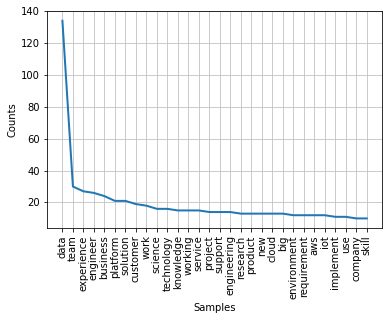

In [ ]:
fdist.plot(30,cumulative=False)
plt.show()

##n-grams: Collocations

Next, we find bigram word collocations using the function "BigramCollocationFinder" from the NLTK package. We show the 30 most frequent bigrams below. Implicitly, we notice various bigrams categories. For example, bigrams such as ('communication', 'skill'), ('close', 'collaboration'), ('team, player'), ('customer', 'service') may refer to a general set of soft skills data-related jobs require for internal and external communication. Next, bigrams such as ('ai', 'engineer'), ('big', 'data'), ('computer', 'science'),('data', 'integration'), ('data', 'pipeline'), ('machine', 'learning') may refer to a general set of hard skills data-related jobs require. Likewise, we notice another interesting bigram, ('bruxelles', 'evere'). This may point to the location dependency of data-related employment in Belgium. Data-related jobs are concentrated in the capital city of Belgium and, in particular, in the municipality of Evere.

In [ ]:
finder = BigramCollocationFinder.from_words(tokenized_word)
bigram_measures = nltk.collocations.BigramAssocMeasures()
sorted(finder.nbest(bigram_measures.raw_freq, 30))

[('ai', 'engineer'),
 ('big', 'data'),
 ('bruxelles', 'evere'),
 ('close', 'collaboration'),
 ('cloud', 'architect'),
 ('communication', 'skill'),
 ('computer', 'science'),
 ('customer', 'service'),
 ('data', 'analytics'),
 ('data', 'cloud'),
 ('data', 'engineer'),
 ('data', 'engineering'),
 ('data', 'integration'),
 ('data', 'pipeline'),
 ('data', 'platform'),
 ('data', 'science'),
 ('data', 'scientist'),
 ('data', 'solution'),
 ('data', 'source'),
 ('de', 'werkgever'),
 ('decathlon', 'belgium'),
 ('degree', 'computer'),
 ('direct', 'de'),
 ('disqover', 'platform'),
 ('junior', 'data'),
 ('machine', 'learning'),
 ('team', 'player'),
 ('use', 'case'),
 ('vacature', 'vacature'),
 ('vito', 'data')]

In [ ]:
finder = TrigramCollocationFinder.from_words(tokenized_word)
trigram_measures = nltk.collocations.TrigramAssocMeasures()
sorted(finder.nbest(trigram_measures.raw_freq, 30))

[('big', 'data', 'cloud'),
 ('close', 'collaboration', 'data'),
 ('collaboration', 'data', 'scientist'),
 ('communication', 'skill', 'english'),
 ('computer', 'science', 'related'),
 ('data', 'analysis', 'data'),
 ('data', 'analytics', 'consultant'),
 ('data', 'cloud', 'architect'),
 ('data', 'science', 'activity'),
 ('data', 'science', 'hub'),
 ('data', 'source', 'develop'),
 ('de', 'werkgever', 'direct'),
 ('de', 'werkgever', 'vacature'),
 ('degree', 'computer', 'science'),
 ('department', 'customer', 'service'),
 ('direct', 'de', 'werkgever'),
 ('diverse', 'data', 'source'),
 ('engineer', 'data', 'science'),
 ('english', 'dutch', 'french'),
 ('experience', 'big', 'data'),
 ('iot', 'sr', 'manager'),
 ('junior', 'data', 'engineer'),
 ('language', 'python', 'r'),
 ('life', 'science', 'healthcare'),
 ('like', 'raw', 'oil'),
 ('master', 'degree', 'computer'),
 ('oorspronkelijke', 'vacature', 'vacature'),
 ('professional', 'service', 'provider'),
 ('rapporteren', 'direct', 'de'),
 ('vacat

Trigrams provide a deeper insight into what skills might be relevant for a data-related job. For instance, we notice the trigrams like  ('english', 'dutch', 'french'), ('communication', 'skill', 'english'), which might refer to language skills an applicant should possess. As we argued above, it might be the case that even though the job description is in English, an application still should speak either French or Dutch or both. Other noticeable trigrams are ('experience', 'big', 'data'), ('language', 'python', 'r'), ('big', 'data', 'cloud'), which might refer to hard skills in big data analytics and cloud services, programming experience in R or Python. Likewise, these trigrams ('master', 'degree', 'computer'), ('computer', 'science', 'related'), ('degree', 'computer', 'science') might point out that an applicant should have a degree in a computer science.

##Identify relevant skills
Here we define a function to check which skill set is relevant for the job search. The function one-hot encodes the skills and adds a 1 for every document they are present in. This way we can get an overview of the popularity of certain skills.


In [ ]:
# function to count how many documents mention a keyword/skill
skill_set = ["sql", "matlab", "python"]


def search_skill(document, skill):
  skill_present = 0
  for word in document.split(" "):
    if (word.lower() == skill):
      skill_present = 1
  return skill_present

# apply it to our data
for skill in skill_set:
  df_english[skill] = df_english.apply(lambda x: search_skill(x.Cleaned_Text, skill), axis = 1)

We can see that SQL is a relevant skill for all job searches, but less for the machine learning engineer. Matlab is more relevant for the data engineer search. Python is mentioned often for all jobs, especially for the data engineer. The data analyst related job descriptions seem to bring up Python skills less often.

In [ ]:
# display pivot table
pd.pivot_table(df_english, index="Job_Category", aggfunc="sum", values=skill_set, margins=True, margins_name='Total') # feature with job descritpion

,matlab,python,sql
Job_Category,,,
business intelligence,9,121,108
data analyst,4,56,114
data engineer,27,250,151
data scientist,12,145,113
machine learning engineer,11,142,44
Total,63,714,530


# Topic Modeling

## Latent Dirichlet Allocation (LDA)
Job listings provide a lot of information on job requirements, purpose, duties and responsibilities. We want to apply LDA to discover the underlying topics that occur in the collection of job listings. We will use these topics to build a multinomial logistic regression model. For this, we will first spilt the dataframe in train and test set and stratify by job category. This is necessary to avoid data leakage.

In [ ]:
#spilt in train and test set
train, test = train_test_split(df_english, test_size=0.25, stratify=df_english['Job_Category'])

We will use the CountVectorizer and fit it to our job description column (Cleaned_Text). We set the maximum document frequency to 80% and the miminum document frequency to 1% to catch the most relevant words. We use unigrams and bigrams for the vectorizer.


In [ ]:
#define vectorizer
vectorizer = CountVectorizer(lowercase   = True,
                             ngram_range = (1,2),
                             min_df=0.01,
                             max_df=0.8)
#fit to cleaned text
vectorizer.fit(train['Cleaned_Text'])
job_tf = vectorizer.transform(train['Cleaned_Text'])

We build the LDA model with 10 components and maximal 150 iterations. The algorithm converged after 80 iterations with a perplexity of 1754.1566.

In [ ]:
#build and fit LDA
lda_model = LatentDirichletAllocation(n_components   = 10,
                                      max_iter       = 150,
                                      evaluate_every = 5,
                                      verbose = 1)
lda_model.fit(job_tf)
lda_model.transform(job_tf)

iteration: 1 of max_iter: 150
iteration: 2 of max_iter: 150
iteration: 3 of max_iter: 150
iteration: 4 of max_iter: 150
iteration: 5 of max_iter: 150, perplexity: 1844.2903
iteration: 6 of max_iter: 150
iteration: 7 of max_iter: 150
iteration: 8 of max_iter: 150
iteration: 9 of max_iter: 150
iteration: 10 of max_iter: 150, perplexity: 1784.0765
iteration: 11 of max_iter: 150
iteration: 12 of max_iter: 150
iteration: 13 of max_iter: 150
iteration: 14 of max_iter: 150
iteration: 15 of max_iter: 150, perplexity: 1770.0356
iteration: 16 of max_iter: 150
iteration: 17 of max_iter: 150
iteration: 18 of max_iter: 150
iteration: 19 of max_iter: 150
iteration: 20 of max_iter: 150, perplexity: 1763.8981
iteration: 21 of max_iter: 150
iteration: 22 of max_iter: 150
iteration: 23 of max_iter: 150
iteration: 24 of max_iter: 150
iteration: 25 of max_iter: 150, perplexity: 1760.2233
iteration: 26 of max_iter: 150
iteration: 27 of max_iter: 150
iteration: 28 of max_iter: 150
iteration: 29 of max_iter:

array([[6.04797026e-01, 3.35625944e-04, 3.35659133e-04, ...,
        3.37074647e-01, 3.35647651e-04, 3.35625231e-04],
       [1.97886415e-01, 2.48177724e-04, 6.58986284e-01, ...,
        2.48178996e-04, 2.48193133e-04, 2.48201464e-04],
       [6.85352431e-01, 2.80944833e-04, 2.80998026e-04, ...,
        2.80959161e-04, 2.12376942e-01, 4.68727662e-02],
       ...,
       [1.45390263e-04, 4.92951555e-02, 1.23982220e-01, ...,
        1.69864691e-01, 6.42808395e-01, 1.33226008e-02],
       [3.02929493e-01, 2.39901613e-04, 4.65892802e-01, ...,
        2.39866051e-04, 2.29498626e-01, 2.39875508e-04],
       [1.21538808e-04, 7.89618715e-01, 1.21543125e-04, ...,
        1.21529234e-04, 2.09409032e-01, 1.21530088e-04]])

Next, we want to get some insight into the topics found by LDA. We use the functions from the class notebook (04d) to display the words associated with the found topics.

In [ ]:
#functions to see which words are related to the topics
def column_swap(column):
    column = column.sort_values(ascending = False)
    return column.index

def topic_words_df(lda_model, vectorizer):
    '''
    Generate dataframe of words associated with a topic model.
    '''
    
    word_topic_scores = lda_model.components_.T
    vocabulary        = vectorizer.get_feature_names()
    
    
    topic_words_df = pd.DataFrame(word_topic_scores,
                                  index = vocabulary)
    
    topic_words_df = topic_words_df.apply(column_swap).reset_index(drop = True).rename_axis('rank')
    
    topic_words_df.index = topic_words_df.index + 1
    
    return topic_words_df

Next, we print the 10 most strongly associated words with the found topics. A possible interpretation is given as follows:

0.   **Techincal Consulting**: Working for clients and providing techinical services to customers. 
1. **Engineering**: optimize clinical processes and energy systems. nside is a company in Louvain-La-Neuve which works in this field. 
2. **Analytics**: analyzing businesses and using company data 
3.  **Supply Chain**: development of supply chain solutions.   
4. **Machine Learning for CRM**: using machnie learning to improve customer relationship management
5.   **Knowlegde discovery**: transform data into knowledge and provide solutions. ONTOFORCE is a company which provides this service.
6. **Project support**: supporting management and engineering processes  
7.   **Product design**: engineering and machine learning to develop new products
8. **Market Reseach**: product and marketing focused jobs
9. **Finanical/ Tax Consulting**: consulting in the field of finance and tax, EY is providing these services




In [ ]:
#get associated words
topic_words_df(lda_model, vectorizer).head(10)

,0,1,2,3,4,5,6,7,8,9
rank,,,,,,,,,,
1,business,nside,business,software,orange,customer,project,engineer,business,service
2,solution,business,analyst,company,customer,disqover,process,software,sale,client
3,client,louvainlaneuve,data analyst,solution,management,platform,quality,learning,product,business
4,project,science,analysis,omp,business,solution,system,technology,customer,analytics
5,technology,development,analytics,cloud,learning,knowledge,management,development,development,ey
6,knowledge,company,insight,development,quality,scientific,knowledge,machine,skill,financial
7,company,process,bi,engineer,machine,service,service,knowledge,opportunity,build
8,service,complex,telenet,siemens,skill,ontoforce,support,engineering,market,working
9,skill,engineer,knowledge,supply,machine learning,data source,group,product,marketing,tax


Next, we display how the topics are associated with the search results for the different queries. We can see that all job search terms are rather strongly related to topic 0 (Technical Consulting). The data analyst and data scientist are related to topic 2 (Analytics). The machine learning engineer is stronger related to topic 4 (Supply Chain) than the other search terms. The data engineer is related to topic 5 and 6 (Knowledge discovery and Project Support). Topic 7 (Product design) is related to the machine learning engineer search term. The search query business intelligence is realted to topic 8 (Market Research). Topic 9 (Finanical/ Tax Consulting) is related to the business intelligence and data scientist search results.

In [ ]:
job_topics = lda_model.transform(job_tf)
topic_df = pd.DataFrame(job_topics)
train = train.reset_index(drop=True)
topic_df.groupby(train['Job_Category']).mean()

,0,1,2,3,4,5,6,7,8,9
Job_Category,,,,,,,,,,
business intelligence,0.297344,0.021923,0.082642,0.020486,0.036971,0.000949,0.137521,0.055722,0.286728,0.059713
data analyst,0.333799,0.027131,0.195116,0.009784,0.016951,0.006944,0.165442,0.059749,0.175489,0.009596
data engineer,0.256368,0.023024,0.016958,0.028954,0.055835,0.069452,0.203231,0.221252,0.118274,0.006653
data scientist,0.288147,0.059969,0.146529,0.033950,0.016953,0.002372,0.075525,0.211584,0.105226,0.059744
machine learning engineer,0.211942,0.090471,0.012127,0.114020,0.054842,0.003195,0.032548,0.379303,0.086730,0.014822


### Classification with LDA topics

Here we build a multinomial logistic regression model with the topics as features. We use the train set to build the model and the test set to evaluate its predictive ability. We use the 'lbfgs' solver because it supports multinomial loss and L2 regularization. We can see that the precision and recall are highest for business intelligence and data engineer. The classification of the machine learning engineer is rather bad. The accuracy of the model is around 50%.

In [ ]:
#build classifier
lr_classifier = LogisticRegression(solver = 'lbfgs', max_iter= 5000)
lr_classifier.fit(job_topics, train['Job_Category'])
#see results on the train set
prediction_train = lr_classifier.predict(job_topics)
print(classification_report(train['Job_Category'], prediction_train))

                           precision    recall  f1-score   support

    business intelligence       0.50      0.69      0.58       551
             data analyst       0.48      0.14      0.22       272
            data engineer       0.53      0.73      0.62       544
           data scientist       0.26      0.03      0.05       196
machine learning engineer       0.25      0.18      0.21       164

                 accuracy                           0.49      1727
                macro avg       0.41      0.35      0.34      1727
             weighted avg       0.46      0.49      0.44      1727



On the test set we achieve approximately the same performance, which means we are not overfitting. In the next sections we will aim for different models to improve the classification.

In [ ]:
#transfrom our test data 
X_test= vectorizer.transform(test['Cleaned_Text'])
test_topics = lda_model.transform(X_test)
#see results on the test set
prediction = lr_classifier.predict(test_topics)
print(classification_report(test['Job_Category'], prediction))

                           precision    recall  f1-score   support

    business intelligence       0.45      0.65      0.53       184
             data analyst       0.43      0.10      0.16        91
            data engineer       0.49      0.69      0.57       181
           data scientist       0.00      0.00      0.00        65
machine learning engineer       0.16      0.09      0.12        55

                 accuracy                           0.45       576
                macro avg       0.31      0.31      0.28       576
             weighted avg       0.38      0.45      0.39       576



##Top2Vec

Another approach we try is Top2Vec. It can be used for topic modeling and sematic search. It assumes that many semantically similar documents are indicative of an underlying topic. It creates a joint embedding in a vector space to find dense clusters of documents. After that it dentifies which words attract the documents together. The dense areas are topics and the words that attract the documents to the dense areas are the topic words. The number of topics is automatically determined by the algorithm. The model finds 41 topics.

In [ ]:
model = Top2Vec(df_english['Cleaned_Text'].tolist(), speed="learn", workers=2)
model.get_num_topics()

2021-06-03 19:16:26,503 - top2vec - INFO - Pre-processing documents for training
2021-06-03 19:16:29,281 - top2vec - INFO - Creating joint document/word embedding
2021-06-03 19:18:19,633 - top2vec - INFO - Creating lower dimension embedding of documents
2021-06-03 19:18:37,760 - top2vec - INFO - Finding dense areas of documents
2021-06-03 19:18:37,845 - top2vec - INFO - Finding topics


41

To get an insight into the topics, we visualize the first 5 topics in word clouds. By looking at the word clouds, we can identify the underlying topics:

0.   **Software Engineering skills**: DevOps, Docker, JavaScript
1.   **Sales and Marketing**: Salesforce, SaaS, CRM
2.   **Electronics**: Systems, Quality Control and Mechanics
3.   **Banking and Consulting**: Workshops, Meetings, Interviews
4.   **Social topics**: Discrimization, Harrassment, Status




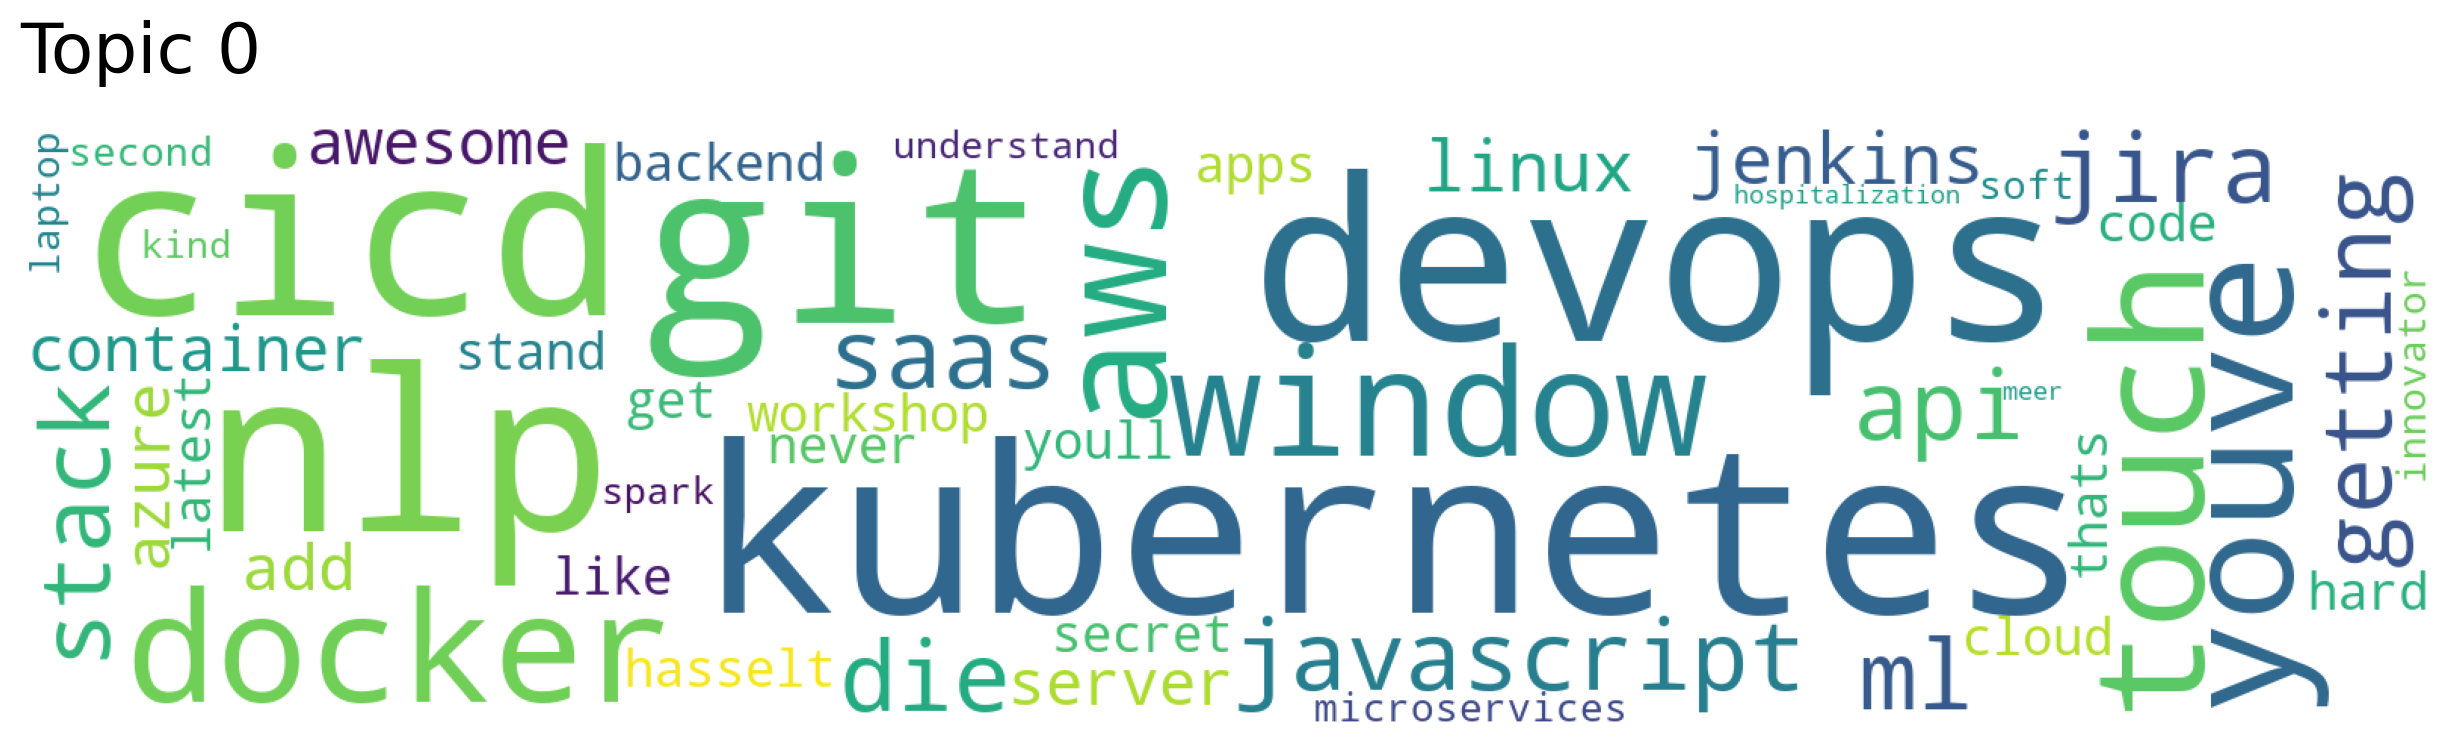

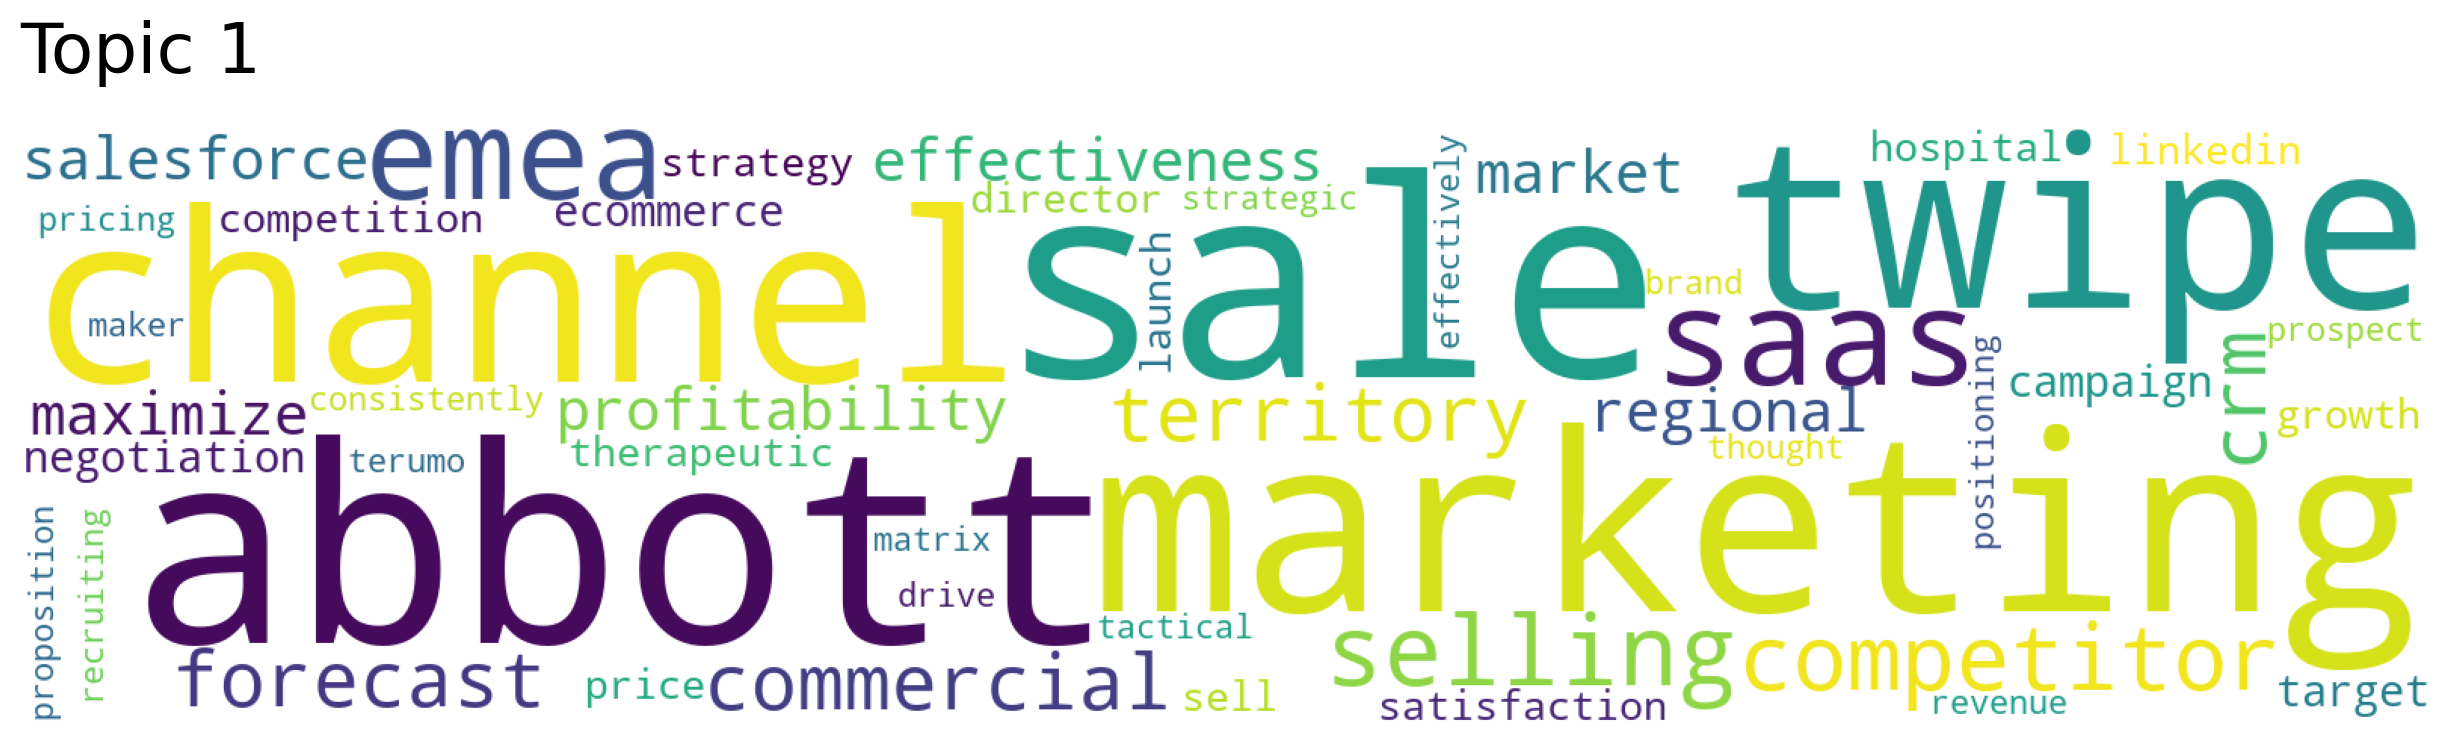

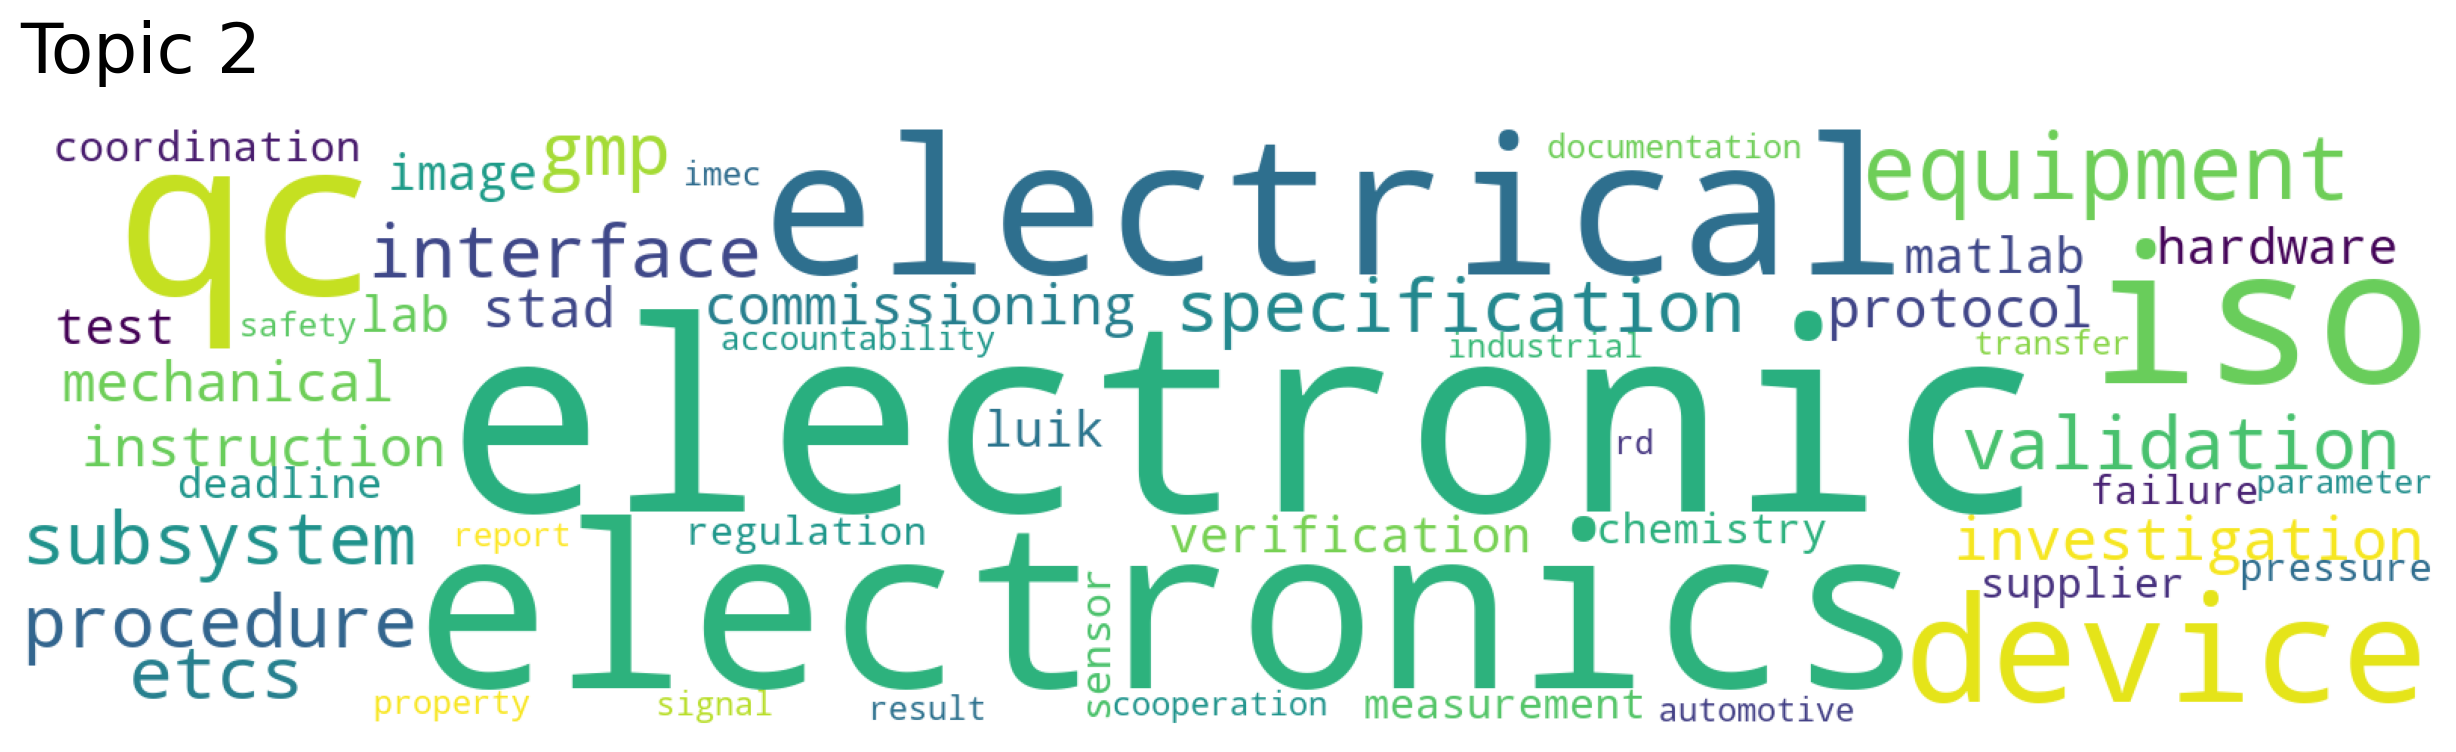

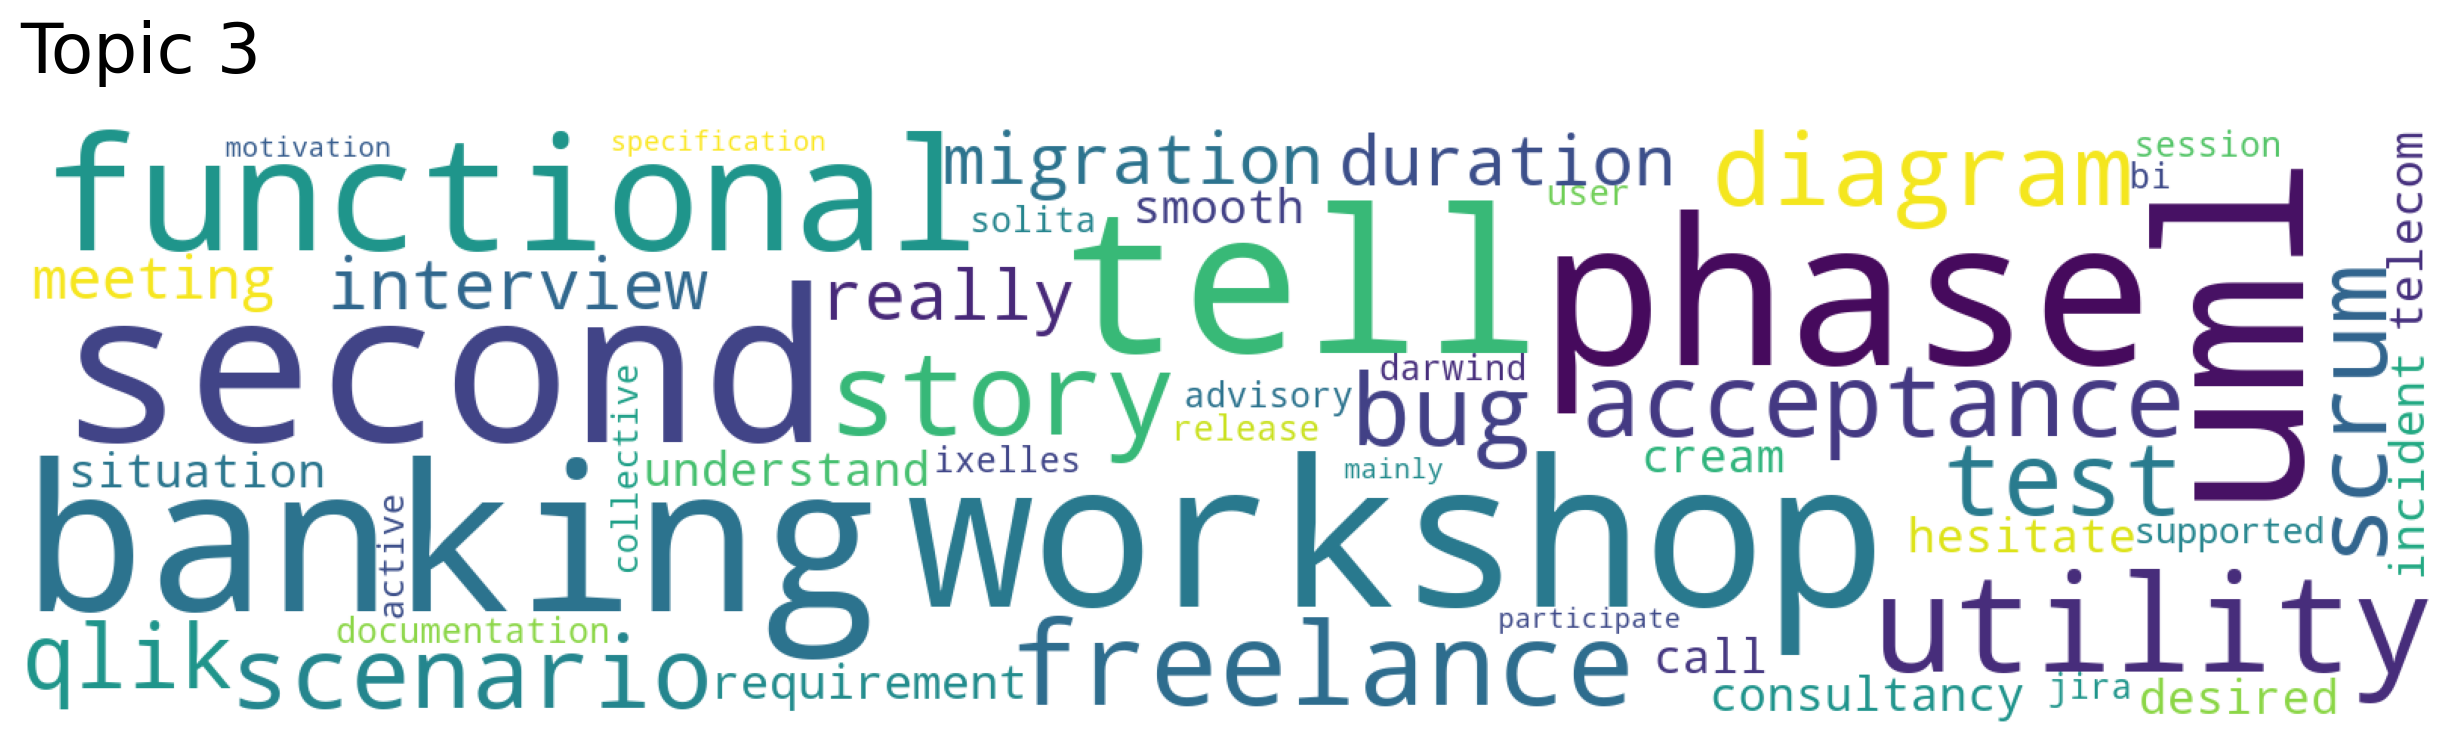

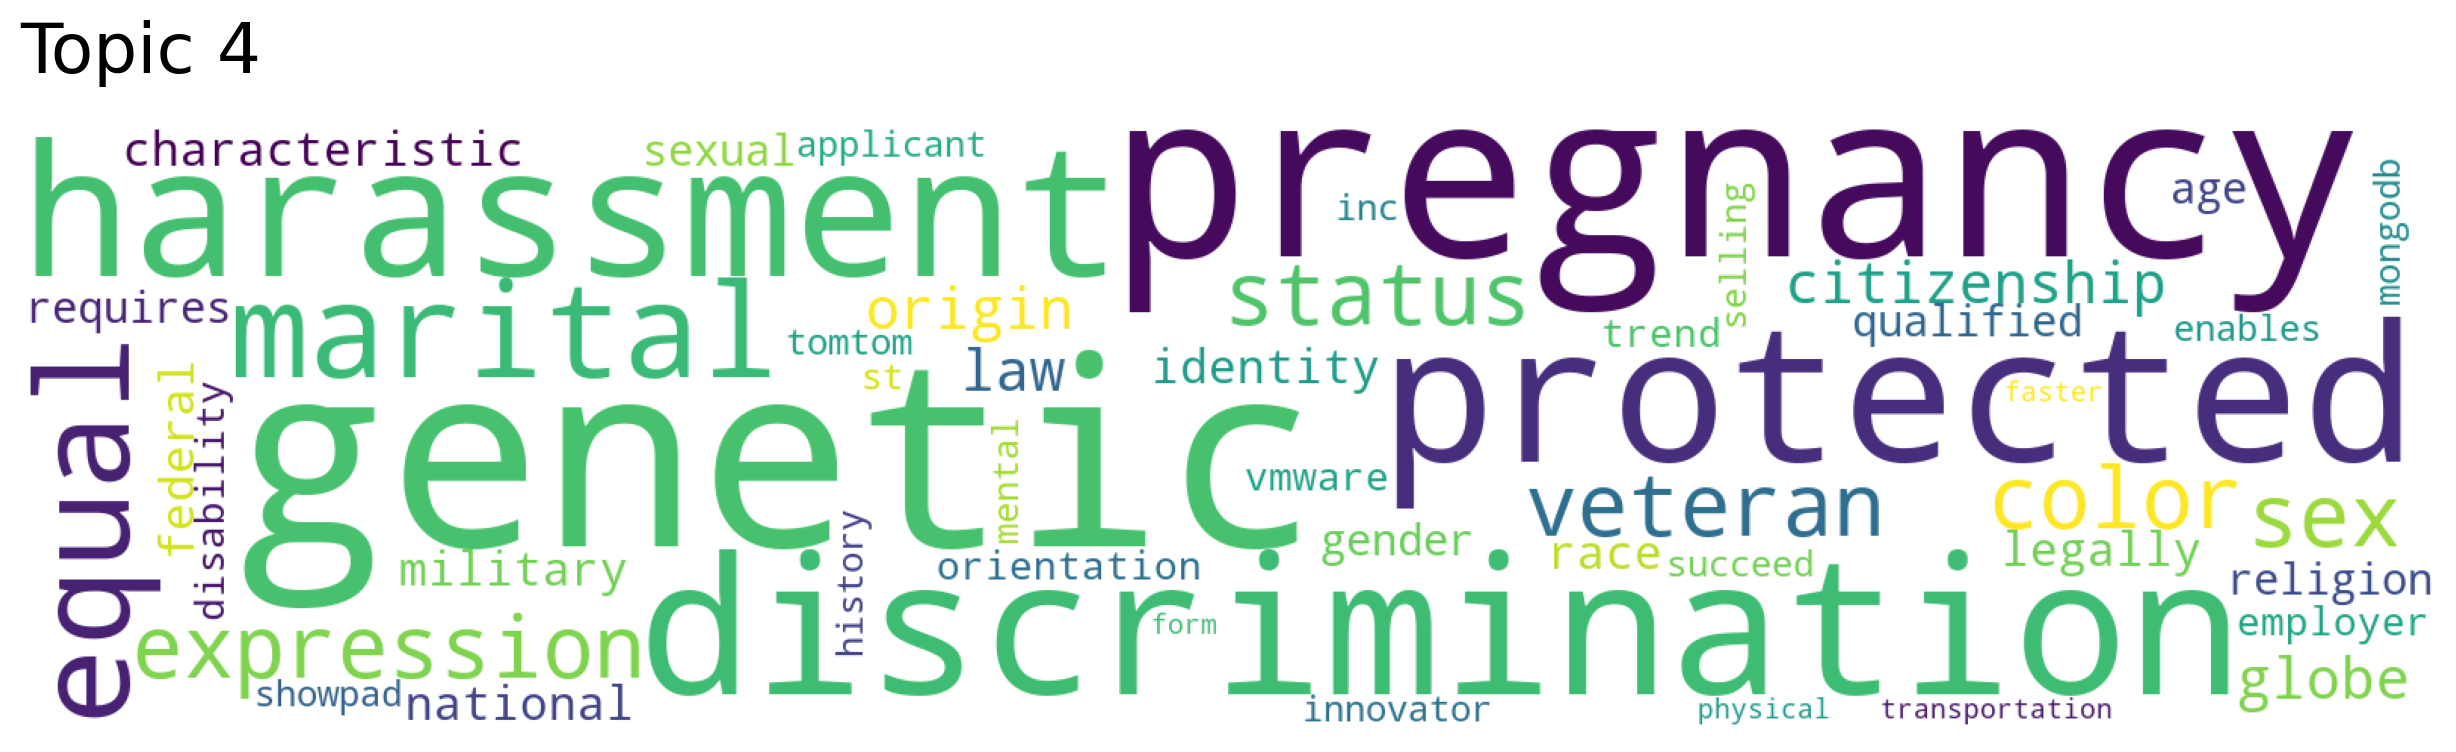

In [ ]:
topic_words, word_scores, topic_nums = model.get_topics(41)
for topic in topic_nums[0:5]:
    model.generate_topic_wordcloud(topic, background_color="white")

The Top2Vec model allows to search the documents by keywords. The documents  are searched for content that is semantically similar. This is based on cosine similarity scores. We can enter a specific skill or keyword, e.g python and find related jobs. A preview of the job description is printed below.

In [ ]:
documents, document_scores, document_ids = model.search_documents_by_keywords(keywords=["Docker", "Matlab", 'python'], num_docs=3)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print("-----------")
    print(doc)
    print("-----------")
    print()

Document: 2268, Score: 0.4536502957344055
-----------
 senior ml engineer faktion bv antwerpen senior machine learning engineer partly computer scientist partly research engineer analytical mind set deep understanding linear algebra statistic provable handson programming experience part applied ai team passionate machine learning deep learning data science general work interesting project world innovative client partner well work internal technology least year work experience love high growth work environment main objective help customer building integrating machine deep learning model design implement stateoftheart method supervised unsupervised machine learning applied natural language spatial sensor image temporal data design implement stateoftheart enrichment method build data fusion platform able ingest acquire process output different kind data ability understand implement stateoftheart academic research paper help apply novel algorithm large volume reallife data help team improv

# Building a Classification Model

In [ ]:
#drop the data engeineer etc from text for predition
#embedding with tfidi
#function from nusret
#grid search
#logistig regression
#word embeddings + tifid model with logistic regression
#maybe random forest


In [ ]:
#maybe deeplearning with text if we are not annoyed already

# Conclusion